# Assignment 7: Neural networks

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

# General instructions

1. Do not remove any text or code cells; do not leave redundent print messages.
1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 3 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. Your code should run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, numba, multiprocessig.
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment7"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Cloud computing with GPU

**In Ex 2 and Ex 3 there is a benefit in running on a computer with a GPU. There are two ways to do that:**
1. Use [**Google Colaboratory**](http://colab.research.google.com) (free.) Colaboratory provides free GPU usage for 12 hours inside a Jupyter notebook. Once you are inside colaboratory, upload this notebook, and change the runtime to Python 3 + GPU. Don't forget to download your notebook when you finish (from the File menu), although it will be saved in your Google Docs.

1. Use **AWS Educate**. You can sign up for an AWS Educate account without a credict card, and get some free credits to use for AWS services. You can get an additional \$50 for this course - just ask for it on Piazza and allow for 24 hrs.
[Instructions are provided](https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/) for setting up a deep learning environment with conda, jupyter, and keras. Note that when you go over the credit limit (\$50) your account will be suspended and you will not have access to your work, so plan accordingly. Some GPU-enabled instances estimated  costs are: p2.xlarge (Tesla K80) 22 USD/day; p3.2xlarge (2 x Tesla v100) 75 USD/day; p3.16xlarge (8 x Tesla v100) 600 USD/day. At this stage you should probably take the cheapest one.

It may be worth the effort: epochs on the dataset used in Ex 2 and Ex 3 take about 15 secs on colaboratory, compared to 40 secs on my laptop. 
But it is not mandatory to work with a GPU, you can use your local CPU.

In [1]:
###
%matplotlib inline

import numpy as np
import scipy.stats

from tensorflow import keras

import seaborn as sns
sns.set_context('notebook')

import matplotlib.pyplot as plt


In [2]:
###
# this code is required for Ex 1
def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
def fully_connected(ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return np.random.uniform(-boundary, boundary, size=(ninputs, noutputs))

def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

def ReLU(X):
    return np.maximum(X, 0)

def dReLU(X):
    return (X > 0).astype(float)

def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

def predict(Ws, X):
    if X.ndim == 1:
        X = X.reshape((1, -1))
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_prediction(idx):
    prediction = predict(Ws, X_test[idx, :]).argmax()
    print(prediction)
    return display_image(X_test[idx])

def loss(Ws, X, Y):
    Yhat = predict(Ws, X)
    return cross_entropy(Yhat, Y)

def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y, keep_prob=1)
    Ws_ = [W.copy() for W in Ws]

    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)
                    
def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates
    
def trainer(Ws, X, Y, optimizer, batch_size=50, keep_prob=1):    
    nsamples = X.shape[0]
    batch = 0
    while True:
        # get next batch
        start = (batch * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = range(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        
        gradients = back_propagation(Ws, X_, Y_, keep_prob=keep_prob) # calculate gradients
        
        ΔWs = optimizer.send(gradients) # calculate updates
        
        for W, ΔW in zip(Ws, ΔWs): # apply updates
            W += ΔW
            
        batch += 1
        yield batch

# Ex 1

Let's load the data for MNIST digits.

In [3]:
###

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

**Implement `feed_forward` and `back_propagation` from the FFN lecture using a `for` loop so that they work for any number of hidden layers.**

Notes: 
- when implementing `back_propagation`, you can use the `gradient_check` function (from `A5.py`) to test that it works as expected.
- please keep the functions signatures as supplied.

In [4]:
def feed_forward(Ws, X, keep_prob=1): ###
    
    # input layer
    layers = [X] 

    # hidden layers
    for i,w in enumerate(Ws[:-1]):
      X = X @ w
      X = drop(X,keep_prob)
      X = ReLU(X)
      layers.append(X)
    
    # final layer
    X = X @ Ws[-1]
    X = softmax(X)
    layers.append(X)

    return layers   
    

In [5]:
def back_propagation(Ws, X, Y, keep_prob=1): ###
    
    gradients = []
    layers = feed_forward(Ws,X,keep_prob) 
    # print('number of layers: ',len(layers))
    # print('number of Ws: ',len(Ws))

    # output layer
    y_hat = layers.pop() 
    δ = y_hat - Y
    
    for i in range(1,len(Ws)+1):
      z = layers.pop()
      
      # get the gradients
      gradients.append(z.T @ δ) 
      
      # stop when reaching input layer - to save computations
      if i == len(Ws):
        break

      # get the layer's loss
      δ = δ @ Ws[-i].T 
      
      # get the activation derivative
      δ *= dReLU(z)

    # reverse the order
    gradients.reverse()

    # sanity checks
    assert len(gradients) == len(Ws), (len(gradients), len(Ws))
    for dW, W in zip(gradients, Ws):
        assert dW.shape == W.shape, (dW.shape, W.shape)
    return gradients

Now **train the FFN model** with 2 or more hidden layers, and print its accuracy on the test set.

I was able to achieve 0.93 test accuracy with about 7-8 seconds of training.

In [6]:
Y_train.shape,X_train.shape


((60000, 10), (60000, 784))

In [7]:
### change the ?s
W1 = fully_connected(X_train.shape[1],64)
W2 = fully_connected(64,32)
W3 = fully_connected(32,10)
Ws = [W1, W2, W3]

batch_size = 100
train = trainer(Ws, X_train, Y_train, batch_size=batch_size, optimizer=AdamOptimizer())

In [8]:
acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy: {:.4f}".format(acc))

Accuracy: 0.0683


In [9]:
### change the ?s
epochs = 10
for batch in train:
    if batch == epochs * nsamples // batch_size: break

acc = accuracy(predict(Ws, X_test), Y_test)
print("Accuracy ({:d}): {:.4f}".format(batch, acc))

Accuracy (6000): 0.9514


# Ex 2

## Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) (MS deep learning package), or [Theano](http://www.deeplearning.net/software/theano/).

The main benefit is that it *allows for easy and fast prototyping*.

Since version 1.4 of TensorFlow, Keras is installed with TensorFlow as a high-level interface to TensorFlow.

## Fashion-MNIST datasetset

The Fashion-MNIST dataset contains 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:


| Label |	Description|
|---|------------------|
| 0 |	T-shirt/top    |
| 1 |	Trouser        |
| 2 |	Pullover       |
| 3 |	Dress          |
| 4 |	Coat           |
| 5 |	Sandal         |
| 6 |	Shirt          |
| 7 |	Sneaker        |
| 8 |	Bag            |
| 9 |	Ankle boot     |

See more information on this dataset in the [keras docs](https://keras.io/datasets/).

In this exercise we will use Keras to train a neural network on the dataset. 

In [10]:
###
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available()) 
print('GPU:', tf.config.list_physical_devices('GPU')) # should use this way
print(tf.test.gpu_device_name())

Keras 2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU: True
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [11]:
###
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

We need to convert the images to a float32 between 0 and 1 and reshape to 28x28x1 (only one channel for black and white) because 2D convolutions expect 3D images (3rd dimension is channel or image).

We also need to one-hot encode the labels, and to scale the data from 0-255 to 0-1.

In [12]:
###
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Let's see the images.

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


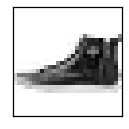

In [13]:
###
i = np.random.randint(0, x_train.shape[0])
plt.figure(figsize=(2,2))
plt.imshow(x_train[i, :, :, 0], cmap='gray_r')
plt.xticks([]); plt.yticks([])
print(y_train[i])

## Using Keras

A Keras model can be built by defining the model layers, then giving them to the `Sequential` model object.
You could also first create the model object and the use its `add` method to add layers.

A `Dense` layer uses matrix muliplication. We need to provide it with the number of outputs, in this case the number of categories, and the activation function, in this case the softmax function.

A `Flatten` layer just flatten the input data - turns it into a 1D array.
The first layer always has to be told the shape of the input (`X`) using `input_shape`.

```python
layers = [
    keras.layers.LayerName(arguments),
    ...
]
model = keras.models.Sequential(layers)
```

After defining the network, we can print a summary using `model.summary()`.
Then, we need to compile the Keras model (which creates the underlying TensorFlow network) and configuring it for training.
At this stage we can choose the [loss function](https://keras.io/api/losses/), the [optimizer](https://keras.io/api/optimizers/), and additional [metrics](https://keras.io/api/metrics/) we with to collect, such as accuracy.

```python
model.compile(
    loss=...,
    optimizer=...,
    metrics=[...]
)
```

After compiling the network, we are ready to train it by giving it the train and test datasets:
Training is done by calling the `fit` method of the model object
```python
model.fit(
    x_train, y_train,
    batch_size=...,
    epochs=...,
    validation_data=(x_test, y_test)
)
```

The `fit` method retuns a `history` object that can be used to plot the accuracy and loss over time (see plot below).

**Build, train, and score a neural network**. 

You can use a feed forward network, or you can use a more sophisticated approach with a convolutional neural network (CNN). Or try both.
As long as you reach a high enough accuracy (>80%) it is fine.

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from time import time
import numpy as np 

import pandas as pd
from tabulate import tabulate


In [15]:
def model_summary_compile_fit_eval(model,x_train,y_train,x_test,y_test):
    model.summary()

    # optimizer & loss function & metric
    opt = keras.optimizers.Adam()
    loss_fn = keras.losses.CategoricalCrossentropy()

    # model compile
    model.compile(loss=loss_fn,optimizer=opt,metrics=['accuracy'])

    # model fit
    train_time = time()
    history = model.fit(x=x_train,y=y_train,epochs=10,batch_size=100,validation_split=0.1)
    train_time = time() - train_time

    # score trained model
    loss, acc = model.evaluate(x_test, y_test, verbose=1)
    
    return (history.history,loss,acc,train_time)

## Dense Model

In [16]:
# reshape train data for dense
input_shape    = np.prod(x_train.shape[1:])
x_train_dense  = x_train.reshape(-1,input_shape)
x_test_dense   = x_test.reshape(-1,input_shape)

# model architecture
model_dense = keras.Sequential()
model_dense.add(keras.Input( (input_shape,)  ))  
model_dense.add(layers.Dense(32,activation='relu'))
model_dense.add(layers.Dense(16,activation='relu'))
model_dense.add(layers.Dense(y_train.shape[1],activation='softmax'))

hist_dense,loss_dense,acc_dense,train_time_dense = model_summary_compile_fit_eval(model_dense,x_train=x_train_dense,y_train=y_train,x_test=x_test_dense,y_test=y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
540/540 [==============================] - 1s 2ms/step - loss: 0.7198 - accuracy: 0.7566 - val_loss: 0.4704 - val_accuracy: 0.8318
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4479 - accuracy: 0.8434 - val_loss: 0.4177 - val_accuracy: 0.8535
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.4073 - accuracy: 0.856

## Convolutional Model
### with the same number of parameters as Dense model




In [17]:
# reshape train data - no need
input_shape = x_train[0].shape

# model architecture
model_conv = keras.Sequential()
model_conv.add(keras.Input(input_shape  )) 
model_conv.add(layers.Conv2D(32, 5, activation="relu"))
model_conv.add(layers.Conv2D(32, 3, activation="relu"))
model_conv.add(layers.MaxPooling2D(3))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(y_train.shape[1],activation='softmax'))

hist_conv,loss_conv,acc_conv,train_time_conv = model_summary_compile_fit_eval(model_conv,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                15690     
Total params: 25,770
Trainable params: 25,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
540/540 [==============================] - 9s 17ms/step - loss: 0.5682 - accuracy: 0.7975 - val_loss: 0.4

## Convolutional Model
### with a smaller number of parameters

In [18]:
# reshape train data - no need
input_shape = x_train[0].shape

# model architecture
model_conv_small = keras.Sequential()
model_conv_small.add(keras.Input(input_shape  )) 
model_conv_small.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model_conv_small.add(layers.MaxPooling2D(3))
model_conv_small.add(layers.Flatten())
model_conv_small.add(layers.Dense(y_train.shape[1],activation='softmax'))

hist_conv_small,loss_conv_small,acc_conv_small,train_time_conv_small = model_summary_compile_fit_eval(model_conv_small,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 12, 12, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 5,962
Trainable params: 5,962
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
540/540 [==============================] - 1s 3ms/step - loss: 0.7402 - accuracy: 0.7535 - val_loss: 0.4874 - val_accuracy: 0.8225
Epoch 2/10
540/540 [==============================] - 1s 3ms/step - loss: 0.4502 - accuracy: 0.8428 - val_lo

# Plot the models results

+---------------------------+----------+------------+-----------------+------------+----------------+
|                           |     Loss |   Accuracy |   Training Time |   # Layers |   # Parameters |
|---------------------------+----------+------------+-----------------+------------+----------------|
| Dense Model               | 0.375802 |     0.8633 |         10.2777 |          3 |          25818 |
| Convolutional Model       | 0.269159 |     0.9055 |         91.9062 |          5 |          25770 |
| Small Convolutional Model | 0.348952 |     0.8734 |         15.1954 |          4 |           5962 |
+---------------------------+----------+------------+-----------------+------------+----------------+


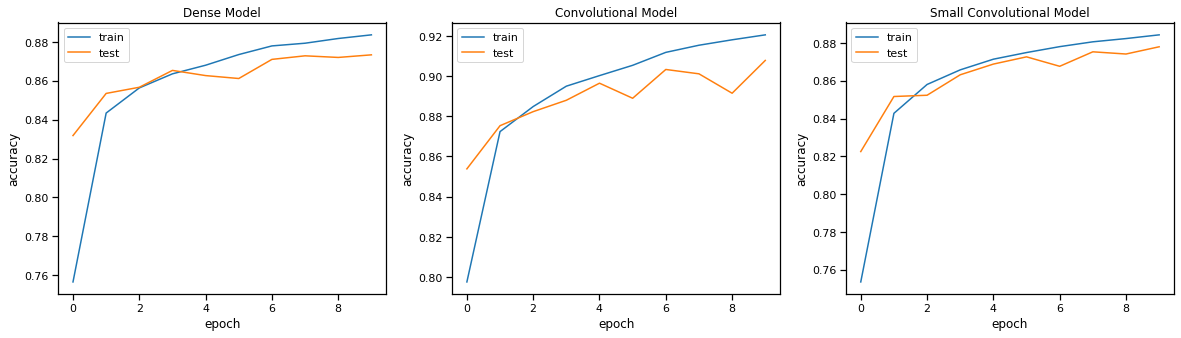

In [19]:
# print loss,acc,time
columns = ['Loss','Accuracy','Training Time','# Layers','# Parameters']
num_layers = [len(model_dense.layers),len(model_conv.layers),len(model_conv_small.layers)]
num_params = [model_dense.count_params(),model_conv.count_params(),model_conv_small.count_params()]

df = pd.DataFrame(columns=columns)
df.loc['Dense Model'] = [loss_dense,acc_dense,train_time_dense,num_layers[0],num_params[0]]
df.loc['Convolutional Model'] = [loss_conv,acc_conv,train_time_conv,num_layers[1],num_params[1]]
df.loc['Small Convolutional Model'] = [loss_conv_small,acc_conv_small,train_time_conv_small,num_layers[2],num_params[2]]

print(tabulate(df,headers='keys',tablefmt='psql'))

# plot accuracy over time
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
titles = ['Dense Model','Convolutional Model', 'Small Convolutional Model']

for ax,hist,title in zip(axes,[hist_dense,hist_conv,hist_conv_small],titles):
  ax.plot(hist['accuracy'], label='train')
  ax.plot(hist['val_accuracy'], label='test')
  ax.set_title(title)
  ax.set_xlabel('epoch')
  ax.set_ylabel('accuracy')
  ax.legend();

# <u>Conclusion</u>  
## In my opinion, I would choose to use the **Small Convolutional Model**.
It has the least amount of parameters and has the smallest training time, while having a high accuracy on the test set.


**end of assignment**

In [24]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:2'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
except RuntimeError as e:
  print(e)